In [1]:
#import data manipulation packages 
import pandas as pd 
import numpy as np 
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt

In [3]:
#import deep learning tools 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import metrics, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.utils import class_weight

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-06-07 04:14:04.426074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 04:14:05.198061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-07 04:14:05.199343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
def process_datasets():
    train_gen=tf.keras.utils.image_dataset_from_directory(directory='./train/',label_mode='categorical',color_mode='grayscale')
    valid_gen=tf.keras.utils.image_dataset_from_directory(directory='./valid/',label_mode='categorical',color_mode='grayscale')
    # test_gen=tf.keras.utils.image_dataset_from_directory(directory='./test/',label_mode='categorical',color_mode='grayscale')
    train_dataset=train_gen.map(
        lambda image,label: ((tf.cast(image,tf.float32),label))
    ).cache().map(
        lambda image,label:(tf.image.random_brightness(image,0.3),label)
    ).map(
        lambda image,label:(tf.image.random_contrast(image, lower=0.5, upper=1.0), label)
    ).shuffle(100).repeat(1)
    valid_gen=valid_gen.map(
        lambda image,label:((tf.cast(image,tf.float32)),label)
    ).cache()
    return train_dataset,valid_gen



In [16]:
train_set,valid=process_datasets()
print('train shape: ',train_set.element_spec)
for image, label in train_set.take(1):
    print("Image shape: ", image.shape)
    print("Label shape: ", label.shape)

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
train shape:  (TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))


2023-06-07 04:15:37.863283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5121]
	 [[{{node Placeholder/_4}}]]
2023-06-07 04:15:37.864216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5121]
	 [[{{node Placeholder/_4}}]]


Image shape:  (32, 256, 256, 1)
Label shape:  (32, 4)


2023-06-07 04:15:40.372314: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
def preprocess(image,label):
    norm_img=tf.cast(image,tf.float32)/255.0
    return norm_img, label

In [ ]:
class_labels=train_gen.classes
print(class_labels)
class_count=Counter(class_labels)
max_val = float(max(class_count.values()))
class_weights = {class_id: max_val / num_images for class_id, num_images in class_count.items()}
print(class_weights)



In [23]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8,kernel_size=(3,3),activation = "relu" , input_shape = (256,256,1)) ,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(32,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(16,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(8,activation="relu"),      #Adding the Hidden layer
    tf.keras.layers.Dropout(0.2,seed = 2019),
    tf.keras.layers.Dense(4,activation ="softmax"),  #Adding the Output Layer
])
model.compile(loss='categorical_crossentropy',metrics=[metrics.CategoricalAccuracy(name='accuracy'),metrics.Precision(name='precision')],optimizer="rmsprop")
model.summary()
#TODO 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 8)       80        
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 127, 127, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 30, 30, 32)      

In [24]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
init_weights=model.get_weights()

model_hist=model.fit(
    train_set,verbose=2,
    epochs=20,
    validation_data=valid, 
    # callbacks=[earlystopping]
    )
model.set_weights(init_weights)


Epoch 1/20


2023-06-07 04:32:46.816190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 72 of 100
2023-06-07 04:33:03.391502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 97 of 100
2023-06-07 04:33:03.403350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 98 of 100
2023-06-07 04:33:03.433507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


161/161 - 118s - loss: 2.6000 - accuracy: 0.4204 - precision: 0.4631 - val_loss: 1.0132 - val_accuracy: 0.5004 - val_precision: 0.5564 - 118s/epoch - 733ms/step
Epoch 2/20
161/161 - 84s - loss: 1.0447 - accuracy: 0.4882 - precision: 0.6138 - val_loss: 1.0634 - val_accuracy: 0.5238 - val_precision: 0.5623 - 84s/epoch - 519ms/step
Epoch 3/20
161/161 - 18s - loss: 0.9757 - accuracy: 0.4946 - precision: 0.6314 - val_loss: 1.0276 - val_accuracy: 0.5528 - val_precision: 0.6010 - 18s/epoch - 110ms/step
Epoch 4/20
161/161 - 29s - loss: 0.9222 - accuracy: 0.5433 - precision: 0.6925 - val_loss: 1.6351 - val_accuracy: 0.5567 - val_precision: 0.5694 - 29s/epoch - 181ms/step
Epoch 5/20
161/161 - 20s - loss: 0.8450 - accuracy: 0.5739 - precision: 0.7192 - val_loss: 1.7450 - val_accuracy: 0.4441 - val_precision: 0.4448 - 20s/epoch - 122ms/step
Epoch 6/20
161/161 - 34s - loss: 0.8187 - accuracy: 0.5934 - precision: 0.7433 - val_loss: 1.8377 - val_accuracy: 0.5129 - val_precision: 0.5397 - 34s/epoch - 

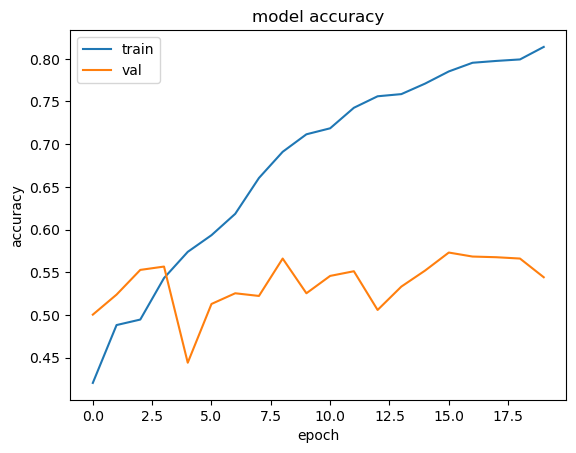

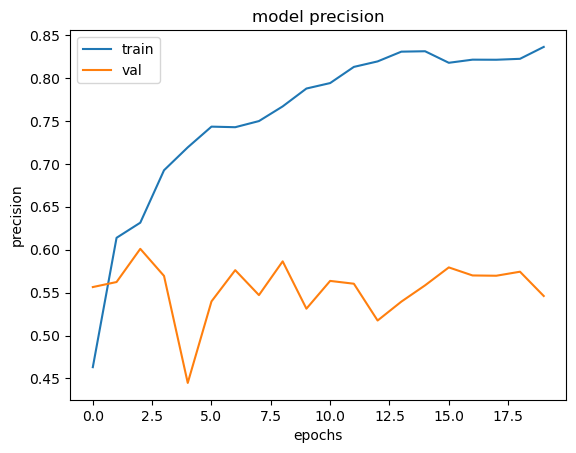

In [27]:
# function to plot accuracy 


history=model_hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']
precision = history['precision']
val_precision= history['val_precision']
epochs=model_hist.epoch

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(precision)
plt.plot(val_precision)
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['train',"val"],loc='upper left')
plt.show()

